In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [112]:
def f(x):
    if 1 <= x <= 3:
        return 1
    if -4.5 <= x <= -2.5:
        return (np.sin(np.pi * x) + 1) / 2
    
    if x < -5:
        return f(x+10) # for periodicity
    if x > 5:
        return f(x-10) # for periodicity
    
    return 0

def ff(xx):
    return np.array([f(x) for x in xx])

# Flux limiter

In [114]:
def upwind(theta):
    return 0 # 6.39a

def LaxWendroff(theta):
    return 1 # 6.39a

def vanLeer(theta):
    # 6.39b
    if theta == np.inf:
        return 2 # limit as theta => inf
    
    return (theta + abs(theta)) / (1 + abs(theta))

In [ ]:
# Eq 6.40 & 6.41
def step_right(QQ, nu, phi=LaxWendroff):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        # mode="wrap" means we can access elements outside of the range and it wraps around to the other end
        return np.take(QQ, i, mode="wrap") 
        
    
    def delta_Q(i): # Eq. 6.31
        left = int(i)
        right = int(i+1)
        return Q(right) - Q(left) 
    
    for i in range(len(Q_next)):
        if abs(delta_Q(i - 0.5)) < 1e-10: # avoid divide by zero
            theta_left = np.inf
        else:
            theta_left = delta_Q(i - 1.5) / delta_Q(i - 0.5) # 6.35, u > 0
        
        if abs(delta_Q(i + 0.5)) < 1e-10: # avoid divide by zero
            theta_right = np.inf
        else:
            theta_right = delta_Q(i - 0.5) / delta_Q(i + 0.5) # 6.35, u > 0
        # equation 6.40, u > 0, nu < 0
        Q_next[i] = Q(i) - nu * (Q(i) - Q(i-1)) - 0.5 * nu * (1 - nu) * (phi(theta_right) * (Q(i+1) - Q(i)) - phi(theta_left) * (Q(i) - Q(i-1)))
    
    return Q_next

def step_left(QQ, nu, phi=LaxWendroff):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        return np.take(QQ, i, mode="wrap")
    
    def delta_Q(i): # Eq. 6.31
        left = int(i)
        right = int(i+1)
        return Q(right) - Q(left) 
    
    for i in range(len(Q_next)):
        if abs(delta_Q(i - 0.5)) < 1e-10:
            theta_left = np.inf
        else:
            theta_left = delta_Q(i + 0.5) / delta_Q(i - 0.5) # 6.35, u < 0
        
        if abs(delta_Q(i + 0.5)) < 1e-10:
            theta_right = np.inf
        else:
            theta_right = delta_Q(i + 1.5) / delta_Q(i + 0.5) # 6.35, u < 0
        # equation 6.41, u < 0, nu < 0
        Q_next[i] = Q(i) - nu * (Q(i+1) - Q(i)) + 0.5 * nu * (1 + nu) * (phi(theta_right) * (Q(i+1) - Q(i)) - phi(theta_left) * (Q(i) - Q(i-1)))
    
    return Q_next

# advection equation

steps per period: 100.0


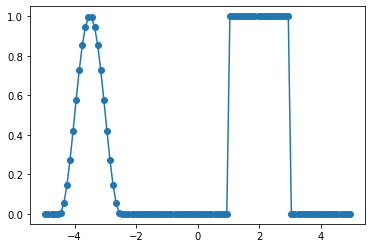

In [141]:
x_left = -5
x_right = 5

u = 1
N = 100
dt = 0.1
dx = (x_right - x_left) / N
nu = u * dt / dx

steps_per_period = (x_right - x_left) / u / dt
print("steps per period:", steps_per_period)

X = np.linspace(x_left, x_right, N, endpoint=False) + 0.5 * dx 
# the last term is to get every point in the center of each volume

Q0 = ff(X)

plt.plot(X, Q0, marker='o')

nu: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

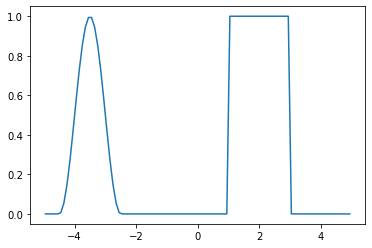

In [140]:
QQ = [Q0]
print("nu:", nu)

Q = Q0
for i in trange(100):
    Q = step_right(Q, nu, vanLeer)
    QQ.append(Q)
    
plt.plot(X, QQ[100])

# Wave equation

In [157]:
def vf(xx):
    return np.array([(f(x), 1) for x in xx])

# this is a vector function, it takes the x positions and returns the initial condition (p(x,0), u(x, 0)) for each point

steps per period: 125.0


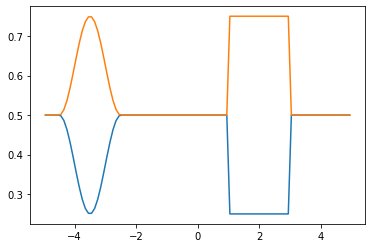

In [165]:
x_left = -5
x_right = 5

u = 2
N = 100
dt = 0.04
dx = (x_right - x_left) / N
nu = u * dt / dx

steps_per_period = (x_right - x_left) / u / dt
print("steps per period:", steps_per_period)

X = np.linspace(x_left, x_right, N, endpoint=False) + 0.5 * dx 
# the last term is to get every point in the center of each volume

Q0 = vf(X)

# c, V = np.linalg.eig(A)
# V = V * np.sqrt(5)
c = np.array([2,-2]) # Eigenvalues of A
V = np.array([
    [-2, 2], 
    [ 1, 1]
]) # Eigenvectors of A
Vinv = np.linalg.inv(V) # V^-1

Q_right0, Q_left0 = Vinv @ vf(X).T # transform the system in a purely left-moving and purely right-moving wave

plt.plot(X, Q_right0)
plt.plot(X, Q_left0)

In [189]:
Q_right = Q_right0
Q_left = Q_left0

QR = [Q_right]
QL = [Q_left]
print("nu:", nu)

method = vanLeer

for i in trange(int(steps_per_period)):
    Q_right = step_right(Q_right, nu, method)
    QR.append(Q_right)
    
    Q_left = step_left(Q_left, -nu, method)
    QL.append(Q_left)

nu: 0.7999999999999999


  0%|          | 0/125 [00:00<?, ?it/s]

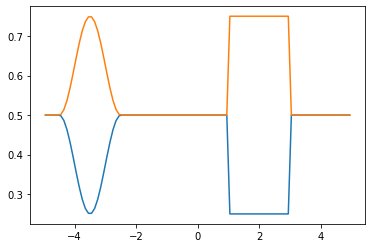

In [190]:
plt.plot(X, QR[0])
plt.plot(X, QL[0])

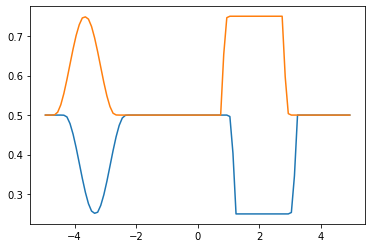

In [191]:
plt.plot(X, QR[2])
plt.plot(X, QL[2])

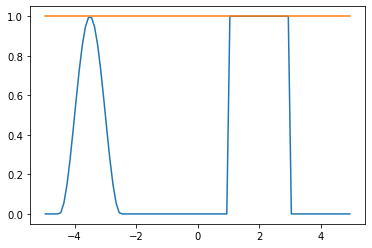

In [192]:
plt.plot(np.array([X,X]).T, (V @ np.array([QR[0],QL[0]])).T)

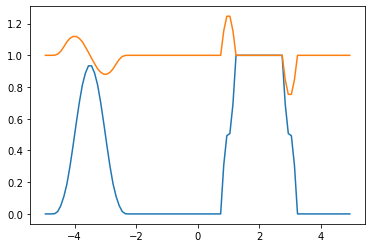

In [193]:
plt.plot(np.array([X,X]).T, (V @ np.array([QR[2],QL[2]])).T)

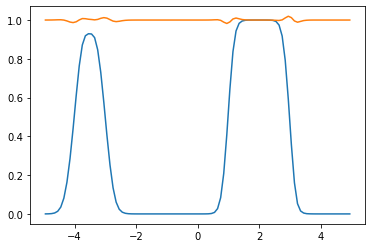

In [194]:
# transform the left and rightmoving wave back to (p, u) coordinates
plt.plot(np.array([X,X]).T, (V @ np.array([QR[int(steps_per_period)],QL[int(steps_per_period)]])).T)

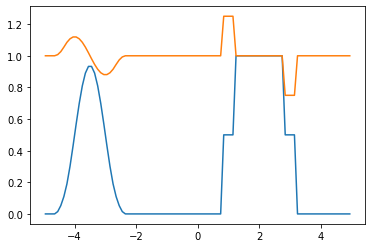

In [195]:
# theory
def p(x,t):
    return 0.5 * (ff(x-2*t) + ff(x+2*t))

def u(x,t):
    return 0.25 * (ff(x+2*t) - ff(x-2*t)) + 1

plt.plot(X, p(X,2*dt))
plt.plot(X, u(X,2*dt))